# Bedrock AgentCore Memory Checkpointer Walkthrough

This sample notebook walks through setup and usage of the Bedrock AgentCore Memory Checkpointer with LangGraph. This approach enables saving of conversations and state data to the Memory API for persistent storage, fault tolerance, and human-in-the-loop workflows.

### Setup
For this notebook you will need:
1. An Amazon Web Services development account
2. Bedrock Model Access (i.e. Claude 3.7 Sonnet)
3. An AgentCore Memory Resource configured (see below section for details)

### AgentCore Memory Resource

Either in the AWS developer portal or using the boto3 library you must create an [AgentCore Memory Resource](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/bedrock-agentcore-control/client/create_memory.html). For just using the `AgentCoreMemorySaver` checkpointer in this notebook, you do not need to specify any specific long-term memory strategies. However, it may be beneficial to supplement this approach with the `AgentCoreMemoryStore` to save and extract conversational insights, so you may want to enable strategies for that use case.

Once you have the Memory enabled and in a `ACTIVE` state, take note of the `memoryId`, we will need it later.

In [1]:
# Install general dependencies
from typing import Annotated, Any, Dict, List

from langchain.chat_models import init_chat_model
from langchain.tools import tool

# Import LangGraph and LangChain components
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict

In [2]:
# Import the AgentCoreMemorySaver that we will use as a checkpointer
# from langgraph_checkpoint_aws.checkpoint.agentcore_memory.saver import AgentCoreMemorySaver
from agentcore_memory.saver import AgentCoreMemorySaver

import logging
logging.getLogger().setLevel(logging.DEBUG)

## AgentCore Memory Configuration
- `REGION` corresponds to the AWS region that your resources are present in, these are passed to the `AgentCoreMemorySaver`.
- `MEMORY_ID` corresponds to your top level AgentCore Memory resource. Within this resource we will store checkpoints for multiple actors and sessions
- `MODEL_ID` this is the bedrock model that will power our LangGraph agent through Bedrock Converse.

We will use the `MEMORY_ID` and any additional boto3 client keyword args (in our case, `REGION`) to instantiate our checkpointer.

In [3]:
REGION = "ap-southeast-2"
MEMORY_ID = "memory_tnpk0-AMDRU75vYn"
MODEL_ID = "apac.anthropic.claude-3-7-sonnet-20250219-v1:0"

# Initialize checkpointer for state persistence
checkpointer = AgentCoreMemorySaver(MEMORY_ID, region_name=REGION)

# Initialize LLM
llm = init_chat_model(MODEL_ID, model_provider="bedrock_converse", region_name=REGION)

In [4]:
# Define agent state and LangGraph graph builder
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

## Define our tools

For this demo notebook we will only give our agent access to two simple tools, adding and multiplying.

In [5]:
@tool
def add(a: int, b: int):
    """Add two integers and return the result"""
    return a + b


@tool
def multiply(a: int, b: int):
    """Multiply two integers and return the result"""
    return a * b


tools = [add, multiply]

# Bind the tools to our LLM so it can understand their structure
llm_with_tools = llm.bind_tools(tools)

## Build our LangGraph agent graph

Our agent will have a few simple nodes, mainly a chatbot node and a tool node. This will enable our chatbot to use the add and multiply tools as much as it needs and then return a response. We will visualize this graph below.

✅ Agent with checkpointing compiled successfully


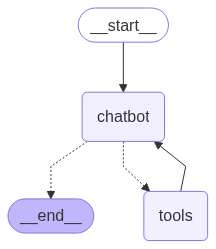

In [6]:
# Our chatbot node will contain the LLM invocation
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Finish off the other edges
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph with our AgentCoreMemorySaver as the checkpointer
graph = graph_builder.compile(checkpointer=checkpointer)

print("✅ Agent with checkpointing compiled successfully")
graph

## IMPORTANT: State and Config


### LangGraph RuntimeConfig
In LangGraph, config is a `RuntimeConfig` that contains attributes that are necessary at invocation time, for example user IDs or session IDs. For the `AgentCoreMemorySaver`, `thread_id` and `actor_id` must be set in the config. For instance, your AgentCore invocation endpoint could assign this based on the identity or user ID of the caller. Additional documentation here: [https://langchain-ai.github.io/langgraphjs/how-tos/configuration/](https://langchain-ai.github.io/langgraphjs/how-tos/configuration/)

### LangGraph Invocation State
The state that is passed to the `graph.invoke` method is an instance of our `State` we defined earlier: 
```
class State(TypedDict):
    messages: Annotated[list, add_messages]
```
As you can see, we have defined messages with the `add_messages` annotation. This means that each node (or invocation) state can return a `messages` key that will simply add the value to the latest value of the `State`. So for example, our chatbot node may return a response such as `messages=["Hi of course I can help you with that"]` and it will be appended to our state messages below instead of overwriting it. For more information on State, see the docs here: [https://langchain-ai.github.io/langgraph/concepts/low_level/#working-with-messages-in-graph-state](https://langchain-ai.github.io/langgraph/concepts/low_level/#working-with-messages-in-graph-state)

In [7]:
# For our demo we will have dummy thread and actor IDs
config = {
    "configurable": {
        "thread_id": "thread-0",
        "actor_id": "user-0",
    }
}

# This invocation state is where you would fill in a query prompt from the user at /invocations
invocation_state = {
    "messages": [HumanMessage("What is 1337 times 200 + 17? Follow pemdas.")]
}

### Run the agent

In [8]:
graph.invoke(invocation_state, config=config)

{'messages': [HumanMessage(content='What is 1337 times 200 + 17? Follow pemdas.', additional_kwargs={}, response_metadata={}, id='b48c5506-2d06-4ba8-8da5-e315ad5cc654'),
  AIMessage(content=[{'type': 'text', 'text': "I'll solve this step by step following PEMDAS (Parentheses, Exponents, Multiplication/Division, Addition/Subtraction).\n\nAccording to PEMDAS, I should perform multiplication before addition. So I'll first multiply 1337 by 200, and then add 17 to that result.\n\nLet me calculate 1337 × 200:"}, {'type': 'tool_use', 'name': 'multiply', 'input': {'a': 1337, 'b': 200}, 'id': 'tooluse_zZPvbVtOR2u2uxjQMtAq_A'}], additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'e1c53591-ec66-4bcc-851e-74e43091ff2f', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 15 Sep 2025 13:45:15 GMT', 'content-type': 'application/json', 'content-length': '691', 'connection': 'keep-alive', 'x-amzn-requestid': 'e1c53591-ec66-4bcc-851e-74e43091ff2f'}, 'RetryAttempts': 0}, 'stopRe

## Inspect the current state with AgentCoreMemory

Under the hood when you call `graph.get_state(config)` it calls the checkpointer to retrieve the latest checkpoint saved for our actor and session. We can take a look at the values saved at this point in the conversation from `messages`.

In [9]:
for message in graph.get_state(config).values.get("messages"):
    print(f"{message.type}: {message.text()}")
    print("=========================================")

human: What is 1337 times 200 + 17? Follow pemdas.
ai: I'll solve this step by step following PEMDAS (Parentheses, Exponents, Multiplication/Division, Addition/Subtraction).

According to PEMDAS, I should perform multiplication before addition. So I'll first multiply 1337 by 200, and then add 17 to that result.

Let me calculate 1337 × 200:
tool: 267400
ai: Now I'll add 17 to this result:
tool: 267417
ai: Following PEMDAS, the answer to 1337 × 200 + 17 is 267,417.
human: Create a LaTeX formula in markdown that shows the previous calculation and results
ai: Here's a LaTeX formula in markdown that shows the previous calculation and results:

```math
1337 \times 200 + 17 = 267400 + 17 = 267417
```

This displays the calculation step by step, showing the multiplication of 1337 by 200 first (following PEMDAS - order of operations), which equals 267400, then the addition of 17 to get the final result of 267417.
human: What is 1337 times 200 + 17? Follow pemdas.
ai: I'll solve this step by st

## Look at a previous checkpoints during execution
Using the `graph.get_state_history(config)` we will see the checkpoints that were saved, then inspect a previous checkpoint's values for `messages`. Checkpoints are listed so the most recent checkpoints appear first.

In [10]:
for checkpoint in graph.get_state_history(config):
    print(
        f"(Checkpoint ID: {checkpoint.config['configurable']['checkpoint_id']}) # of messages in state: {len(checkpoint.values.get('messages'))}"
    )

(Checkpoint ID: 1f0923ae-b162-61aa-800f-bba4b057543e) # of messages in state: 14
(Checkpoint ID: 1f0923ae-a40f-61e2-800e-bc65f256d255) # of messages in state: 13
(Checkpoint ID: 1f0923ae-a3ff-6c38-800d-505d7ed13c25) # of messages in state: 12
(Checkpoint ID: 1f0923ae-918a-6f26-800c-7b2ebf1316a2) # of messages in state: 11
(Checkpoint ID: 1f0923ae-9173-629a-800b-b53ad08339fe) # of messages in state: 10
(Checkpoint ID: 1f0923ae-72c7-6ab2-800a-5b5912be455a) # of messages in state: 9
(Checkpoint ID: 1f0923ae-72bd-6e0e-8009-33e40701ee42) # of messages in state: 8
(Checkpoint ID: 1f0923a4-6e20-6324-8008-16ed6f369bd9) # of messages in state: 8
(Checkpoint ID: 1f0923a4-5323-6b48-8007-e1247fbfc0cb) # of messages in state: 7
(Checkpoint ID: 1f0923a4-530f-6a62-8006-4b60a52adca0) # of messages in state: 6
(Checkpoint ID: 1f0923a3-7efb-649c-8005-acd1eb738210) # of messages in state: 6
(Checkpoint ID: 1f0923a3-6fa2-62a2-8004-a44cd9675857) # of messages in state: 5
(Checkpoint ID: 1f0923a3-6f9b-69d4-

## Continue the conversation
By using the same config with our session and actor from before, we can continue the conversation by invoking our LangGraph agent with a new invocation state. The checkpointer in the background will take care of loading in context so that all the previous messages from the first interaction are loaded in.

In [11]:
# This invocation state is where you would fill in a query prompt from the user at /invocations
invocation_state = {
    "messages": [
        HumanMessage(
            "Create a LaTeX formula in markdown that shows the previous calculation and results"
        )
    ]
}
graph.invoke(invocation_state, config=config)

# Display the response
graph.get_state(config).values.get("messages")[-1]

AIMessage(content="Here's a LaTeX formula in markdown that shows the previous calculation and results:\n\n```math\n1337 \\times 200 + 17 = 267400 + 17 = 267417\n```\n\nThis displays the calculation step by step, showing the multiplication of 1337 by 200 first (following PEMDAS - order of operations), which equals 267400, then the addition of 17 to get the final result of 267417.", additional_kwargs={}, response_metadata={'ResponseMetadata': {'RequestId': 'cf97747e-d4d4-49bf-b801-56253cc788c2', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Mon, 15 Sep 2025 13:50:36 GMT', 'content-type': 'application/json', 'content-length': '659', 'connection': 'keep-alive', 'x-amzn-requestid': 'cf97747e-d4d4-49bf-b801-56253cc788c2'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': [2207]}, 'model_name': 'apac.anthropic.claude-3-7-sonnet-20250219-v1:0'}, id='run--88043c79-6656-47e0-b489-ad0219b553f0-0', usage_metadata={'input_tokens': 1218, 'output_tokens': 106, 'total_tokens':

## Wrapping Up

As you can see, the AgentCore checkpointer is very powerful for persisting conversational and graph state in the background. 